In [6]:
from time import time
import unittest
import numpy as np
import pickle
import keras
from sklearn.metrics import silhouette_score

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1' 

from keras.datasets import mnist
from keras.metrics import binary_accuracy
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))

import sys  
sys.path.append('../')
from util.util import *
from util import importNotebook
from module.autoencoder import AE, VAE, ConvVAE

In [11]:
class TestAE(unittest.TestCase):
    
    numEpochs = 10
    sizeBatch = 128
    sizeKernel = 3
    layerDense = [16, 2]
    nameOptim = 'adam'
    pathTempBest = '../model/temp/'
    patience = 3
    
    (xTrain, yTrain), (xTest, yTest) = mnist.load_data()
    xTrain = xTrain.astype('float32') / 255.
    xTest = xTest.astype('float32') / 255.
    numTrain = len(xTrain)
    numTest = len(xTest)
    sizeDigit = xTrain.shape[1:]

    dimInput = np.prod(xTrain.shape[1:])
    xTrain = xTrain.reshape((numTrain, dimInput))
    xTest = xTest.reshape((numTest, dimInput))
    print(xTrain.shape)
    print(xTest.shape)
    
    def test_init(self):
        ae = AE(self.dimInput, layerDense=self.layerDense)
        ae.encoder.summary()
        ae.decoder.summary()
        ae.autoencoder.summary()
        self.ae = ae

    def test_fit(self):
        history, timeTrain = self.ae.fit(self.xTrain, self.xTest, 
                                         numEpochs=self.numEpochs,
                                         sizeBatch=self.sizeBatch,
                                         pathTempBest=self.pathTempBest)
        
    def test_fit_check_best(self):
        history, timeTrain = self.ae.fit(self.xTrain, self.xTest, 
                                          numEpochs=20,
                                          patience = 1,
                                          sizeBatch=self.sizeBatch,
                                          metrics=["binary_accuracy"],
                                          pathTempBest=self.pathTempBest)
        # print the binary accuracy of testing dataset for verifying best model
        print(tf.keras.backend.eval(binary_accuracy(self.xTest, self.ae.autoencoder.predict(self.xTest))).mean())
        
    
    def test_save_seperate(self):
        self.ae.encoder.save('../model/test/AE/encoder.h5')
        self.ae.decoder.save('../model/test/AE/decoder.h5')

    def test_save(self):
        self.ae.save('../model/test/AE/ae')
        
    def test_load_seperate(self):
        encoder = keras.models.load_model('../model/test/AE/encoder.h5')
        decoder = keras.models.load_model('../model/test/AE/decoder.h5')
#         autoencoder = keras.models.load_model('./temp/autoencoder.h5', custom_objects={'lossae': lossae})
        encoder.summary()
        decoder.summary()
#         autoencoder.summary()
        encodeTest = encoder.predict(self.xTest)
        decodeTest = decoder.predict(encodeTest)
#         decodeTest2 = autoencoder.predict(self.xTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
#         Plot the comparison of original and reconstructed pictures, and calculate the errors
        plotCompDecode(self.xTest, decodeTest, sizeDigit=self.sizeDigit)
        err = compReconst(self.xTest, decodeTest)
        print(err)
        
        
    def test_load(self):
        encoder, decoder, autoencoder = AE.load('../model/test/AE/ae')
        encoder.summary()
        decoder.summary()
        autoencoder.summary()
        encodeTest = encoder.predict(self.xTest)
        decodeTest = decoder.predict(encodeTest)
        decodeTest2 = autoencoder.predict(self.xTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plotCompDecode(self.xTest, decodeTest, sizeDigit=self.sizeDigit)
        err = compReconst(self.xTest, decodeTest)
        print(err)
        
    
    def test_prediction(self):
        # Set the initialization
        xTrain = self.xTrain
        xTest = self.xTest
        yTest = self.yTest
        sizeDigit = self.sizeDigit
        ae = self.ae
        encoder = ae.encoder
        decoder = ae.decoder
        
        # Get encoded and decoded values
        encodeTest = encoder.predict(xTest)
        decodeTest = decoder.predict(encodeTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plotCompDecode(xTest, decodeTest, sizeDigit=sizeDigit)
        err = compReconst(xTest, decodeTest)
        print(err)
        
        # Plot the scatter of the encoding space
        xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
        ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])
        plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
        scoreSilh = silhouette_score(encodeTest, yTest)    
        
        # Plot the decoding results from the encoding scatter
        plotScatterDecode(decoder, sizeDigit, xlim, ylim)

(60000, 784)
(10000, 784)


In [12]:
class TestVAE(unittest.TestCase):
    
    numEpochs = 10
    sizeBatch = 128
    sizeKernel = 3
    layerDense = [16, 2]
    ratRecon = 1
    nameOptim = 'adam'
    pathTempBest = '../model/temp/'
    patience = 3
    
    (xTrain, yTrain), (xTest, yTest) = mnist.load_data()
    xTrain = xTrain.astype('float32') / 255.
    xTest = xTest.astype('float32') / 255.
    numTrain = len(xTrain)
    numTest = len(xTest)
    sizeDigit = xTrain.shape[1:]

    dimInput = np.prod(xTrain.shape[1:])
    xTrain = xTrain.reshape((numTrain, dimInput))
    xTest = xTest.reshape((numTest, dimInput))
    print(xTrain.shape)
    print(xTest.shape)
    
    def test_init(self):
        vae = VAE(self.dimInput, layerDense=self.layerDense, ratRecon=self.ratRecon)
        vae.encoder.summary()
        vae.decoder.summary()
        vae.autoencoder.summary()
        self.vae = vae

    def test_fit(self):
        history, timeTrain = self.vae.fit(self.xTrain, self.xTest, 
                                          numEpochs=self.numEpochs,
                                          sizeBatch=self.sizeBatch,
                                          pathTempBest=self.pathTempBest)
        
    def test_fit_check_best(self):
        history, timeTrain = self.vae.fit(self.xTrain, self.xTest, 
                                          numEpochs=20,
                                          patience = 1,
                                          sizeBatch=self.sizeBatch,
                                          metrics=["binary_accuracy"],
                                          pathTempBest=self.pathTempBest)
        print(tf.keras.backend.eval(binary_accuracy(self.xTest, self.vae.autoencoder.predict(self.xTest))).mean())
        
    
    def test_save_seperate(self):
        self.vae.encoder.save('../model/test/VAE/encoder.h5')
        self.vae.decoder.save('../model/test/VAE/decoder.h5')

    def test_save(self):
        self.vae.save('../model/test/VAE/vae')
        
    def test_load_seperate(self):
        encoder = keras.models.load_model('../model/test/VAE/encoder.h5')
        decoder = keras.models.load_model('../model/test/VAE/decoder.h5')
#         autoencoder = keras.models.load_model('./temp/autoencoder.h5', custom_objects={'lossVAE': lossVAE})
        encoder.summary()
        decoder.summary()
#         autoencoder.summary()
        encodeTest = encoder.predict(self.xTest)
        decodeTest = decoder.predict(encodeTest)
#         decodeTest2 = autoencoder.predict(self.xTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
#         Plot the comparison of original and reconstructed pictures, and calculate the errors
        plotCompDecode(self.xTest, decodeTest, sizeDigit=self.sizeDigit)
        err = compReconst(self.xTest, decodeTest)
        print(err)
        
        
    def test_load(self):
        encoder, decoder, autoencoder = VAE.load('../model/test/VAE/vae')
        encoder.summary()
        decoder.summary()
        autoencoder.summary()
        encodeTest = encoder.predict(self.xTest)
        decodeTest = decoder.predict(encodeTest)
        decodeTest2 = autoencoder.predict(self.xTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plotCompDecode(self.xTest, decodeTest, sizeDigit=self.sizeDigit)
        err = compReconst(self.xTest, decodeTest)
        print(err)
        
    
    def test_prediction(self):
        # Set the initialization
        xTrain = self.xTrain
        xTest = self.xTest
        yTest = self.yTest
        sizeDigit = self.sizeDigit
        vae = self.vae
        encoder = vae.encoder
        decoder = vae.decoder
        
        # Get encoded and decoded values
        encodeTest = encoder.predict(xTest)
        decodeTest = decoder.predict(encodeTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plotCompDecode(xTest, decodeTest, sizeDigit=sizeDigit)
        err = compReconst(xTest, decodeTest)
        print(err)
        
        # Plot the scatter of the encoding space
        xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
        ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])
        plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
        scoreSilh = silhouette_score(encodeTest, yTest)    
        
        # Plot the decoding results from the encoding scatter
        plotScatterDecode(decoder, sizeDigit, xlim, ylim)

(60000, 784)
(10000, 784)


In [13]:
class TestConvVAE(unittest.TestCase):
    
    numEpochs = 10
    sizeBatch = 128
    sizeKernel = 3
    layerDense = [16, 2]
    layerConv = [4, 16]
    ratRecon = 1
    nameOptim = 'adam'
    pathTempBest = '../model/temp/'
    patience = 3
    
    (xTrain, yTrain), (xTest, yTest) = mnist.load_data()
    xTrain = xTrain.astype('float32') / 255.
    xTest = xTest.astype('float32') / 255.
    numTrain = len(xTrain)
    numTest = len(xTest)
    sizeDigit = xTrain.shape[1:]
    dimInput = [*xTrain.shape[1:], 1]
    xTrain = xTrain.reshape((numTrain, *dimInput))
    xTest = xTest.reshape((numTest, *dimInput))
    print(xTrain.shape)
    print(xTest.shape)
    
    def test_init(self):
        convVAE = ConvVAE(self.dimInput, layerDense=self.layerDense, layerConv=self.layerConv, ratRecon=self.ratRecon)
        convVAE.encoder.summary()
        convVAE.decoder.summary()
        convVAE.autoencoder.summary()
        self.convVAE = convVAE

    def test_fit(self):
        history, timeTrain = self.convVAE.fit(self.xTrain, self.xTest, 
                                              numEpochs=self.numEpochs,
                                              sizeBatch=self.sizeBatch,
                                              pathTempBest=self.pathTempBest)

        
    def test_save(self):
        self.convVAE.save('../model/test/ConvVAE/convVAE')
        
    def test_load(self):
        encoder, decoder, autoencoder = ConvVAE.load('../model/test/ConvVAE/convVAE')
        encoder.summary()
        decoder.summary()
        autoencoder.summary()
        encodeTest = encoder.predict(self.xTest)
        decodeTest = decoder.predict(encodeTest)
        decodeTest2 = autoencoder.predict(self.xTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plotCompDecode(self.xTest, decodeTest, sizeDigit=self.sizeDigit)
        err = compReconst(self.xTest, decodeTest)
        print(err)
        
    def test_prediction(self):
        # Set the initialization
        xTrain = self.xTrain
        xTest = self.xTest
        yTest = self.yTest
        sizeDigit = self.sizeDigit
        convVAE = self.convVAE
        encoder = convVAE.encoder
        decoder = convVAE.decoder
        
        # Get encoded and decoded values
        encodeTest = encoder.predict(xTest)
        decodeTest = decoder.predict(encodeTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plotCompDecode(xTest, decodeTest, sizeDigit=sizeDigit)
        err = compReconst(xTest, decodeTest)
        print(err)
        
        # Plot the scatter of the encoding space
        xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
        ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])
        plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
        scoreSilh = silhouette_score(encodeTest, yTest)  
        
        # Plot the decoding results from the encoding scatter
        plotScatterDecode(decoder, sizeDigit, xlim, ylim)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                12560     
_________________________________________________________________
batch_normalization_3 (Batch (None, 16)                64        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
Total params: 12,658
Trainable params: 12,626
Non-trainable params: 32
_________________________________________________________________
_____

60000/60000 [==============================] - 3s 47us/step - loss: 0.2328 - binary_accuracy: 0.7955 - val_loss: 0.2230 - val_binary_accuracy: 0.7972

Epoch 00019: val_loss improved from 0.22305 to 0.22295, saving model to ../model/temp//AutoEncoder1536633021.8633904.hdf5
Epoch 20/20
60000/60000 [==============================] - 3s 47us/step - loss: 0.2326 - binary_accuracy: 0.7955 - val_loss: 0.2228 - val_binary_accuracy: 0.7973

Epoch 00020: val_loss improved from 0.22295 to 0.22283, saving model to ../model/temp//AutoEncoder1536633021.8633904.hdf5
0.79730666


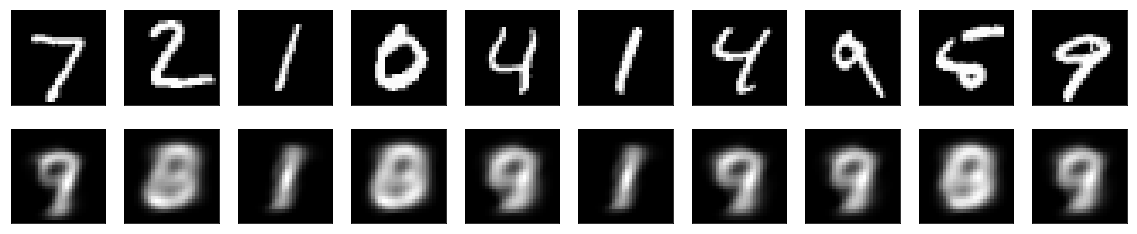

0.234828


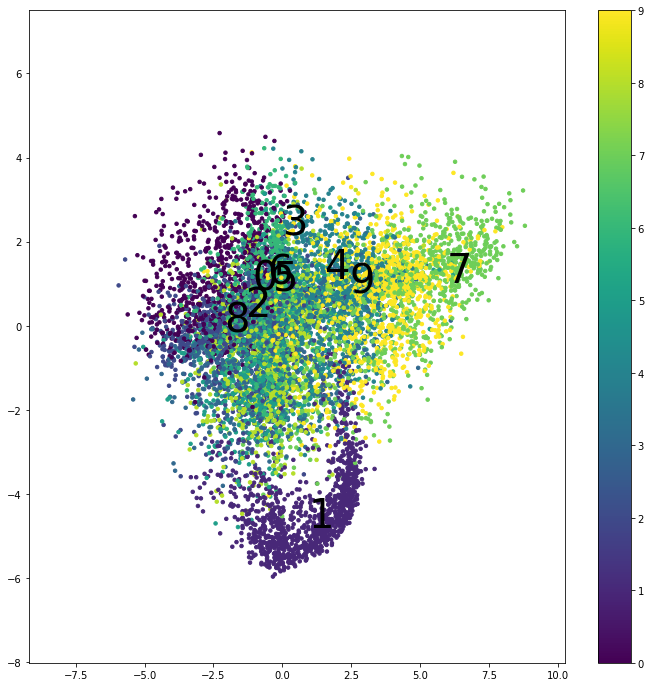

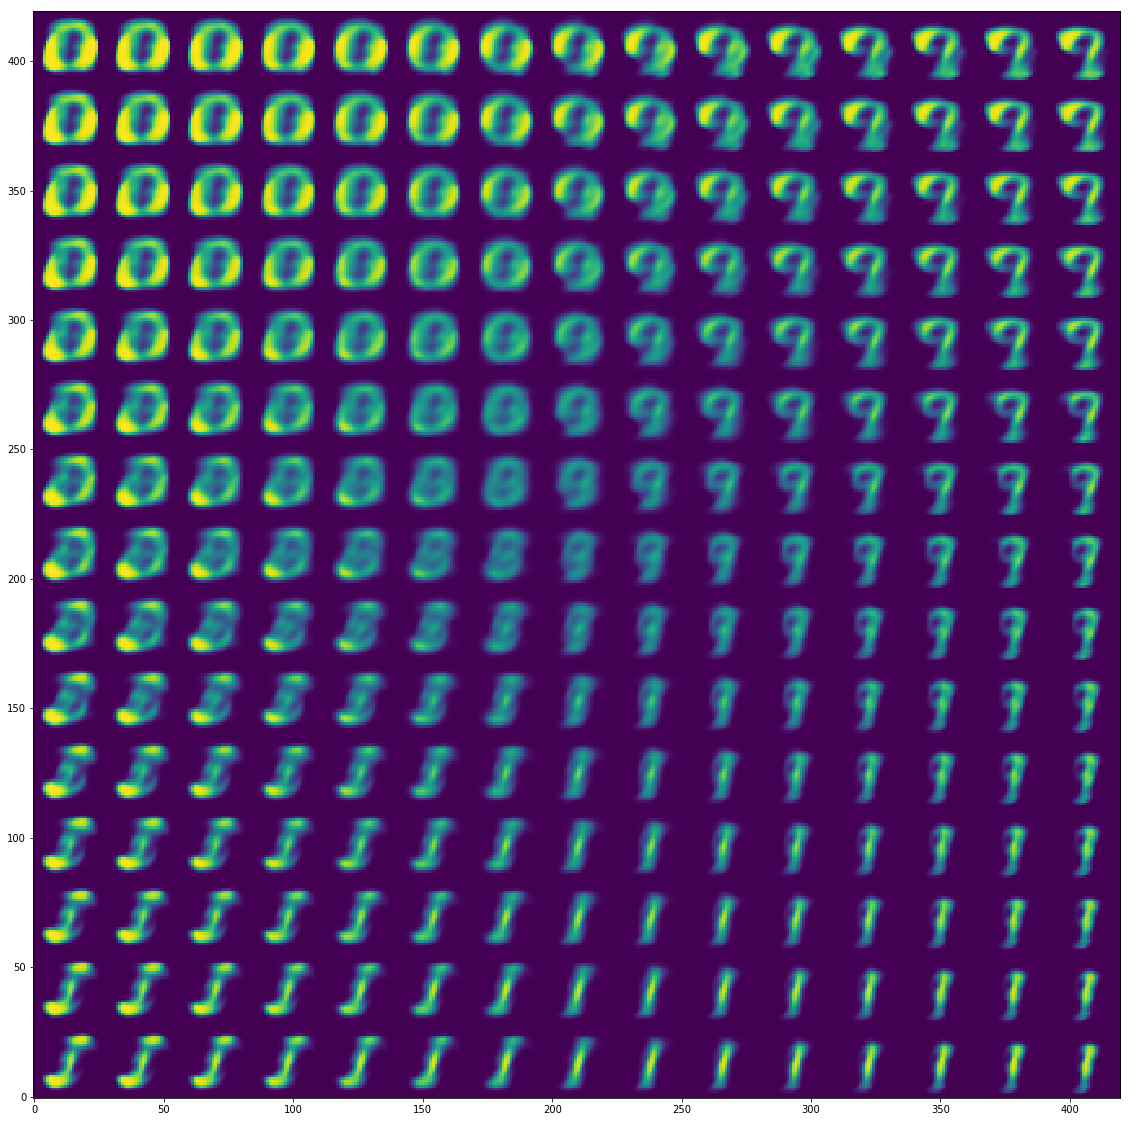

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                12560     
_________________________________________________________________
batch_normalization_3 (Batch (None, 16)                64        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
Total params: 12,658
Trainable params: 12,626
Non-trainable params: 32
_________________________________________________________________
_____

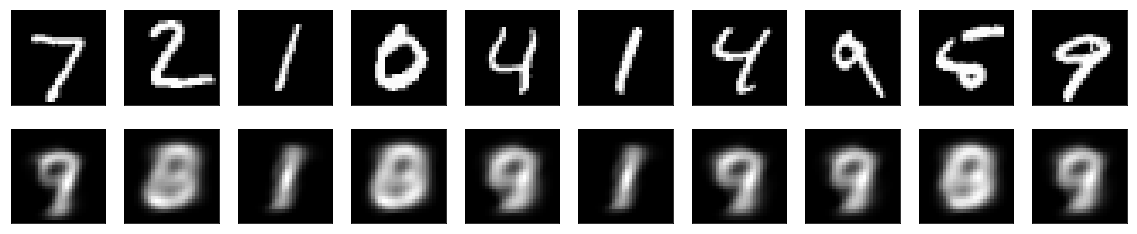

0.234828


In [14]:
if __name__ == '__main__':
    testAE = TestAE()
    testAE.test_init()
#     testAE.test_fit()
    testAE.test_fit_check_best()
    testAE.test_prediction()
    testAE.test_save()
    testAE.test_load()
    
#     testVAE = TestVAE()
#     testVAE.test_init()
#     testVAE.test_fit()
# #     testVAE.test_fit_check_best()
#     testVAE.test_prediction()
#     testVAE.test_save()
#     testVAE.test_load()
    
#     testConv = TestConvVAE()
#     testConv.test_init()
#     testConv.test_fit()
#     testConv.test_prediction()
#     testConv.test_save()
#     testConv.test_load()

In [ ]:
# from keras.datasets import mnist
# import numpy as np
# numEpochs = 2
# sizeBatch = 128
# sizeKernel = 3
# layerDense = [16, 2]
# ratRecon = 1
# nameOptim = 'adam'
# modelPath = '../model/temp/'
# patience = 3
# stdEps = 1.0

# (xTrain, yTrain), (xTest, yTest) = mnist.load_data()
# xTrain = xTrain.astype('float32') / 255.
# xTest = xTest.astype('float32') / 255.
# numTrain = len(xTrain)
# numTest = len(xTest)
# sizeDigit = xTrain.shape[1:]

# dimInput = np.prod(xTrain.shape[1:])
# xTrain = xTrain.reshape((numTrain, dimInput))
# xTest = xTest.reshape((numTest, dimInput))
# print(xTrain.shape)
# print(xTest.shape)


# layerDense=[64, 2] 
# actDense='relu'
# ratRecon=0.998
# dimEncode = layerDense[-1]

# inputs = Input(shape=(dimInput,)) 
# x = inputs

# # Stack of Dense layers
# for numFilt in layerDense[:-1]:
#     x = Dense(numFilt, activation=actDense)(x)
# zMean = Dense(dimEncode)(x)
# zSigmaLog = Dense(dimEncode)(x) # log for linear dense

# def sampling(args):
#     zMean, zSigmaLog = args
#     epsilon = K.random_normal(shape=(K.shape(zMean)[0], K.shape(zMean)[1]),
#                               mean=0., stddev=stdEps)
#     return zMean + K.exp(zSigmaLog) * epsilon  
    
# # Construct the latent as the output and build the encorder pipeline
# z = Lambda(sampling)([zMean, zSigmaLog])
# encoder = Model(inputs, z, name='encoder')

# # Build the Decoder Model
# inputLatent = Input(shape=(dimEncode,), name='decoder_input')
# x = inputLatent
# for numFilt in layerDense[-2::-1]:
#     x = Dense(numFilt, activation=actDense)(x)

# # Reconstruct the pixels as the output and build the decorder pipeline
# outputs = Dense(dimInput, activation='sigmoid', name='decoder_output')(x)
# decoder = Model(inputLatent, outputs, name='decoder')

# autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

# def lossVAE(tensorInput, tensorDecode):
#     zMean = zMean
#     zSigmaLog = zSigmaLog
#     ratRecon = ratRecon

#     lossRecon =  metrics.binary_crossentropy(K.flatten(tensorInput), K.flatten(tensorDecode))
# #         lossRecon =  metrics.mean_squared_error(K.flatten(tensorInput), K.flatten(tensorDecode))
#     lossKL = - 0.5 * K.sum(1 + 2 * zSigmaLog - K.square(zMean) - K.square(K.exp(zSigmaLog)), axis=-1)
#     return ratRecon * lossRecon + (1 - ratRecon) * lossKL

# autoencoder.compile(optimizer=nameOptim, loss=lossVAE)

# history = autoencoder.fit(xTrain, xTrain,
#                           epochs=numEpochs,
#                           batch_size=sizeBatch, shuffle=True,
#                           callbacks=callbacks,
#                           validation_data=(xValid, xValid)
#                          )
# vae.encoder.save('./encoder.h5')